### Cell2location estimates which combination of cell types in which cell abundance could have given the mRNA counts in the spatial data

Given cell type annotation for each cell, the corresponding reference cell type signatures 𝑔𝑓,𝑔, which represent the average mRNA count of each gene 𝑔 in each cell type 𝑓, can be estimated from sc/snRNA-seq data using 2 provided methods (see below)

1) estimation of reference cell type signatures

    1) NB 
    2) average gene expression in each cluster 
    
2) cell2location maping 

In [1]:
import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from matplotlib_scalebar.scalebar import ScaleBar
import os

import cell2location
import scvi

DPI = 300
FONTSIZE = 20  # 42
sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

from matplotlib import rcParams
import seaborn as sns
from pathlib import Path

Global seed set to 0


In [2]:
# DIR2SAVE the signatures
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/"
)

In [3]:
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = DIR2SAVE.joinpath("reference_signatures-noCyclingTME/")
ref_run_name.mkdir(parents=True, exist_ok=True)

* **scRNA-seq reference**

In [4]:
# load path to single cell RNA-seq data reference
SC_RNA_DATA = "/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/prepareInputRNA/Multiome_Che_Wu_CRC_LM_annotations_raw_no_cycling_TME.h5ad"
adata_sc = sc.read_h5ad(SC_RNA_DATA)

In [5]:
adata_sc.shape

(112034, 39559)

## Estimation of reference cell type signatures (NB regression)

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

Preparing anndata.

First, prepare anndata object for the regression model:

In [6]:
set(adata_sc.obs.Annotation_scVI_detailed)

{'B',
 'C1QC Mac',
 'C3 iCAF',
 'CD4 Tfh',
 'CD4 Th',
 'CD4 Th HSP',
 'CD4 Th17',
 'CD4 Tn',
 'CD8 Tem',
 'CD8 Tem GZMB',
 'CD8 Tem HSP',
 'CD8 Tex',
 'Cholangiocyte',
 'Colonocyte',
 'ECM CAF',
 'Enteroendocrine',
 'FCN1 Mono',
 'Goblet',
 'HSP Mono',
 'Hepatocyte',
 'Hypoxia',
 'IL1B Mac',
 'Intermediate',
 'Kupffer',
 'Lymphatic endo',
 'MAIT',
 'Mast',
 'Myofibroblast',
 'NK1',
 'NK2',
 'NKT',
 'NLRP3 Mac',
 'Neutrophil',
 'PLTP LYVE1 Mac',
 'Pericyte',
 'Plasma',
 'SEC',
 'SMC',
 'SPP1 Mac',
 'Stalk-like endo',
 'Stem',
 'Stem (NOTUM high)',
 'TA1',
 'TA2',
 'Tip-like endo',
 'Treg',
 'Tuft',
 'UPR',
 'cDC1',
 'cDC2',
 'gdT',
 'ipEMT',
 'migDC',
 'pDC',
 'pEMT'}

**Need to make sure that there are no / in the annotations because the model doesn't like it for saving it creates errors**

In [7]:
adata_sc.obs.Annotation_scVI_detailed = (
    adata_sc.obs.Annotation_scVI_detailed.str.replace("/", "-")
)  # creates errors when saving

### Perform permissive genes selection

**2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG) which is prone to deleting markers of rare populations**:


1. Include all genes expressed by at least 5% of cells (cell_count_cutoff2)

2. Include genes expressed by at least 0.05% of cells (cell_count_cutoff) when they have high counts in non-zero cells (nonz_mean_cutoff)


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


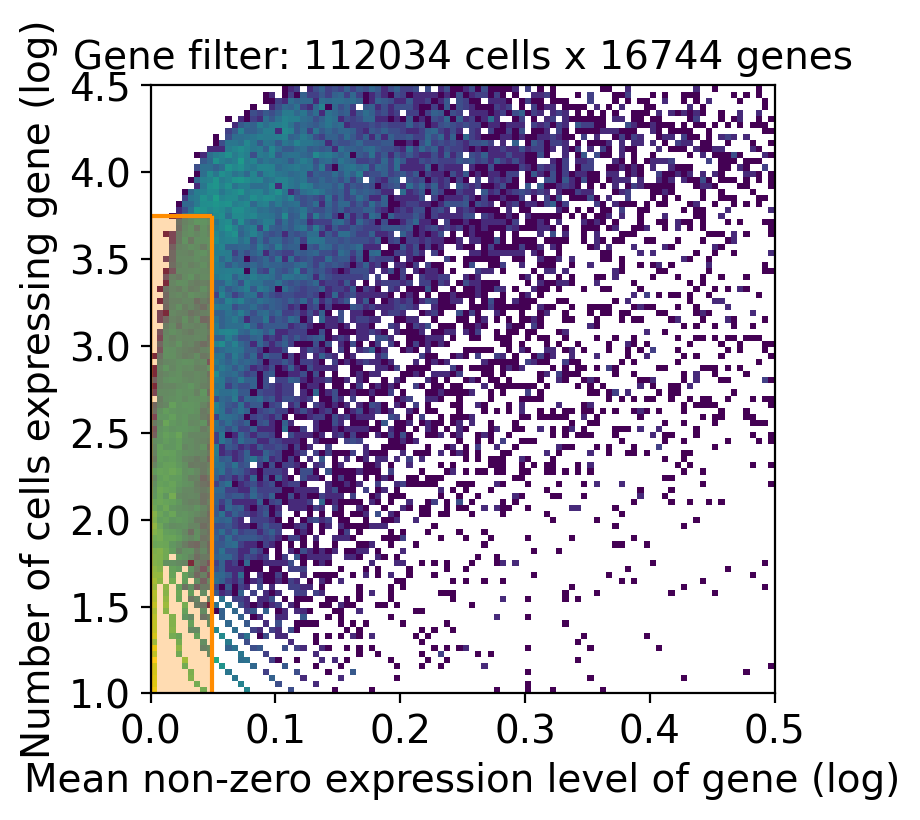

(112034, 16744)

In [8]:
from cell2location.utils.filtering import filter_genes

selected = filter_genes(
    adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.12
)

# filter the object
adata_sc = adata_sc[:, selected].copy()
adata_sc.shape

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis)

#### 1. prepare anndata object for the regression model

In [9]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(
    adata=adata_sc,
    # 10X reaction / sample / batch
    batch_key="cell_source",  # which dataset: multiome, che, wu
    # cell type, covariate used for constructing signatures
    labels_key="Annotation_scVI_detailed",
    # multiplicative technical effects (platform, 3' vs 5', donor effect)
    categorical_covariate_keys=["technology"],  # nuclei vs cells
)

In [10]:
# create the regression model
from cell2location.models import RegressionModel

mod = RegressionModel(adata_sc)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'cell_source',
│   'labels_key': 'Annotation_scVI_detailed',
│   'categorical_covariate_keys': ['technology'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_cells          │ 112034 │
│          n_vars          │ 16744  │
│         n_batch          │   3    │
│         n_labels         │   55   │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│         labels         │         adata.obs['_scvi_labels']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_source'] │ BCI-Nuclei │          0          │
│                          │ Che-Cells  │          1          │
│                          │  Wu-Cells  │          2          │
└──────────────────────────┴────────────┴─────────────────────┘

                               labels State Registry                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃            Source Location            ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Annotation_scVI_detailed'] │         B         │          0          │
│                                       │     C1QC Mac      │          1          │
│                                       │      C3 iCAF      │          2          │
│                                       │      CD4 Tfh      │          3          │
│                                       │      CD4 Th       │          4          │
│                                       │    CD4 Th HSP     │          5          │
│                                       │     CD4 Th17      │          6          │
│                                       │      CD4 Tn       │          7          │
│                                       │      CD8 Tem      │          8          │
│                                       │   CD8 Tem GZMB    │          9          │
│                                       │    CD8 Tem HSP    │         10          │
│                                       │      CD8 Tex      │         11          │
│                                       │   Cholangiocyte   │         12          │
│                                       │    Colonocyte     │         13          │
│                                       │      ECM CAF      │         14          │
│                                       │  Enteroendocrine  │         15          │
│                                       │     FCN1 Mono     │         16          │
│                                       │      Goblet       │         17          │
│                                       │     HSP Mono      │         18          │
│                                       │    Hepatocyte     │         19          │
│                                       │      Hypoxia      │         20          │
│                                       │     IL1B Mac      │         21          │
│                                       │   Intermediate    │         22          │
│                                       │      Kupffer      │         23          │
│                                       │  Lymphatic endo   │         24          │
│                                       │       MAIT        │         25          │
│                                       │       Mast        │         26          │
│                                       │   Myofibroblast   │         27          │
│                                       │        NK1        │         28          │
│                                       │        NK2        │         29          │
│                                       │        NKT        │         30          │
│                                       │     NLRP3 Mac     │         31          │
│                                       │    Neutrophil     │         32          │
│                                       │  PLTP LYVE1 Mac   │         33          │
│                                       │     Pericyte      │         34          │
│                                       │      Plasma       │         35          │
│                                       │        SEC        │         36          │
│                                       │        SMC        │         37          │
│                                       │     SPP1 Mac      │         38          │
│                                       │  Stalk-like endo  │         39          │
│                                       │       Stem        │         40          │
│                                       │ Stem (NOTUM high) │         41          │
│                                       │        TA1        │         42          │
│                                       │        TA2

            extra_categorical_covs State Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['technology'] │   Cells    │          0          │
│                         │   Nuclei   │          1          │
│                         │            │                     │
└─────────────────────────┴────────────┴─────────────────────┘

#### 2. Training model.

Now we train the model to estimate the reference cell type signatures.

Note that to achieve convergence on your data (=to get stabilization of the loss) you may need to increase max_epochs=250 (See below).

Also note that here we are using batch_size=2500 which is much larger than scvi-tools default and perform training on all cells in the data (train_size=1) - both parameters are defaults.

In [11]:
mod.train(
    max_epochs=500, use_gpu=True, batch_size=2500, train_size=1, lr=0.002
)  # max_epochs=250, 1000

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [1:23:54<00:00, 10.07s/it, v_num=1, elbo_train=4.69e+8]


Determine if the model needs more training.

Here, we plot ELBO loss history during training, removing first 20 epochs from the plot. This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, increase max_epochs

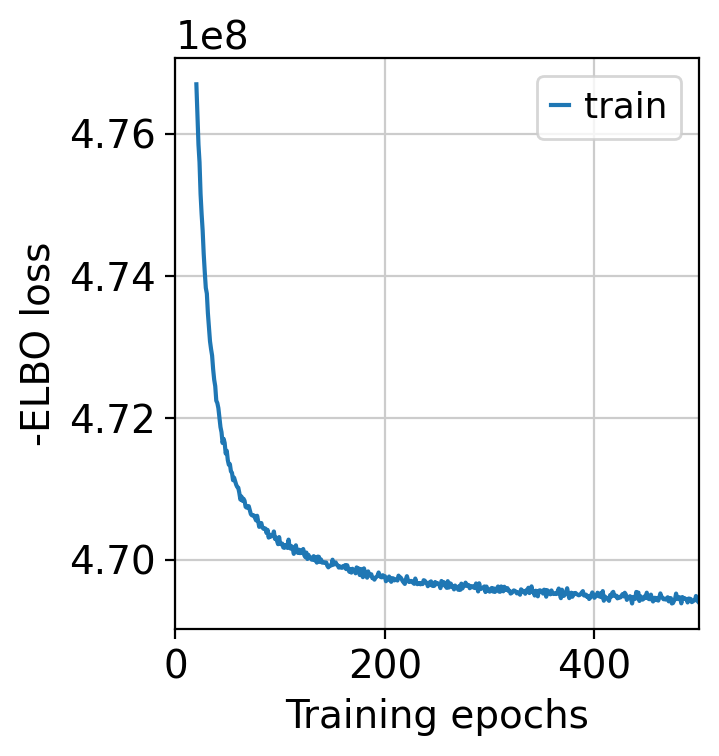

In [12]:
# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [13]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_sc = mod.export_posterior(
    adata_sc, sample_kwargs={"num_samples": 1000, "batch_size": 2500, "use_gpu": True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_sc.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:15<00:00, 63.41it/s]


'/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/reference_signatures-noCyclingTME/sc.h5ad'

Examine QC plots.

Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal.

The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

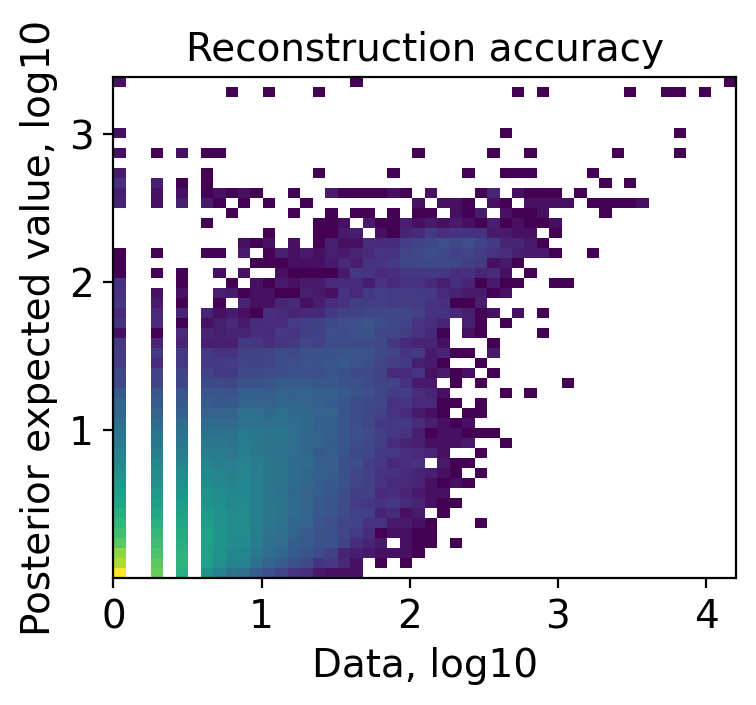

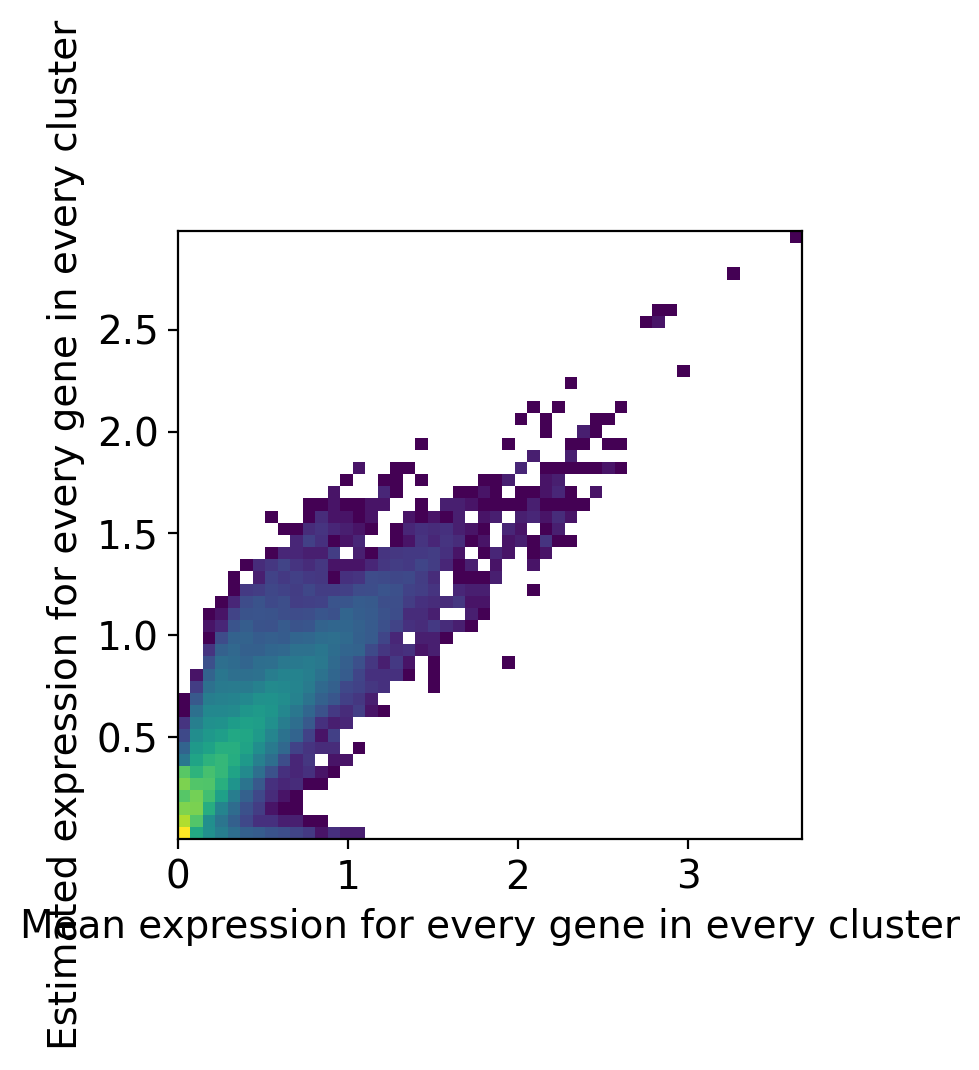

In [14]:
mod.plot_QC()

In [15]:
# The model and output h5ad can be loaded later like this:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/
         cell2location/reference_signatures-noCyclingTME/model.pt already downloaded         
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/179:   1%|          | 1/179 [00:00<00:44,  3.98it/s, v_num=1, elbo_train=5.29e+8]


In [16]:
# export estimated expression in each cluster
if "means_per_cluster_mu_fg" in adata_ref.varm.keys():
    inf_aver = adata_ref.varm["means_per_cluster_mu_fg"][
        [f"means_per_cluster_mu_fg_{i}" for i in adata_ref.uns["mod"]["factor_names"]]
    ].copy()
else:
    inf_aver = adata_ref.var[
        [f"means_per_cluster_mu_fg_{i}" for i in adata_ref.uns["mod"]["factor_names"]]
    ].copy()
inf_aver.columns = adata_ref.uns["mod"]["factor_names"]
inf_aver.iloc[0:5, 0:5]

,B,C1QC Mac,C3 iCAF,CD4 Tfh,CD4 Th
A1BG,0.217940,0.603945,0.482844,0.183307,0.175969
A1CF,0.004003,0.005245,0.064358,0.000937,0.001401
A2M,0.014990,4.373756,1.854340,0.014480,0.021270
A2ML1-AS1,0.001355,0.004277,0.106408,0.000953,0.000283
A4GALT,0.008324,0.006817,0.419700,0.001703,0.000249


/tmp/2929267.1.all.q/ipykernel_13065/460581447.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(


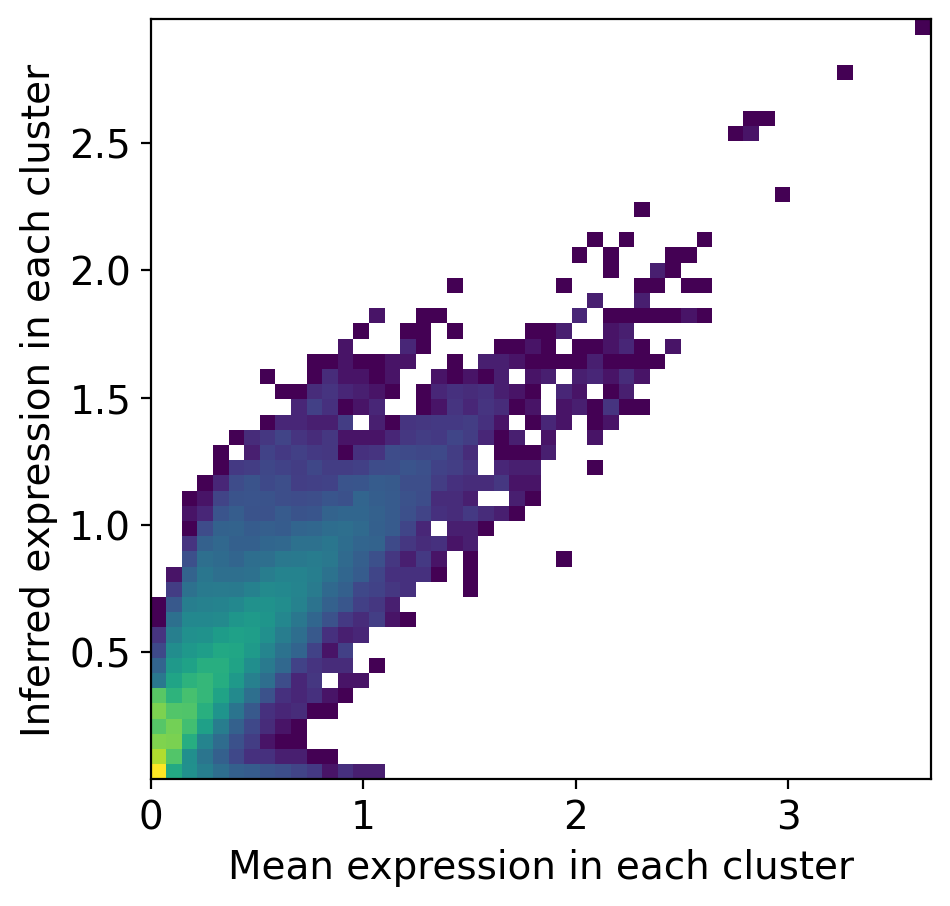

In [17]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.compute_cluster_averages(
    adata_ref,
    "Annotation_scVI_detailed",
    use_raw=False,
)

aver = aver.loc[adata_ref.var_names, inf_aver.columns]

rcParams["figure.figsize"] = 5, 5
plt.hist2d(
    np.log10(aver.values.flatten() + 1),
    np.log10(inf_aver.values.flatten() + 1),
    bins=50,
    norm=mpl.colors.LogNorm(),
)
plt.xlabel("Mean expression in each cluster")
plt.ylabel("Inferred expression in each cluster");

In [18]:
import scipy

scipy.stats.spearmanr(
    np.log10(aver.values.flatten() + 1),
    np.log10(inf_aver.values.flatten() + 1),
    alternative="greater",
)

SpearmanrResult(correlation=0.6827376227345364, pvalue=0.0)

In [19]:
inf_aver

,B,C1QC Mac,C3 iCAF,CD4 Tfh,CD4 Th,CD4 Th HSP,CD4 Th17,CD4 Tn,CD8 Tem,CD8 Tem GZMB,...,Treg,Tuft,UPR,cDC1,cDC2,gdT,ipEMT,migDC,pDC,pEMT
A1BG,0.217940,0.603945,0.482844,0.183307,0.175969,0.184936,0.192955,0.222691,0.182361,0.212900,...,0.216614,0.070041,0.020696,0.422260,0.664235,0.157502,0.045557,1.243111,1.045869,0.057498
A1CF,0.004003,0.005245,0.064358,0.000937,0.001401,0.001161,0.006749,0.002363,0.001194,0.004450,...,0.001556,0.351876,1.010199,0.033245,0.003747,0.002778,0.684595,0.103623,0.013481,0.971335
A2M,0.014990,4.373756,1.854340,0.014480,0.021270,0.014963,0.022565,0.016489,0.033004,0.024875,...,0.017959,0.027839,0.003000,0.290771,0.548362,0.014302,0.003520,0.071323,0.015167,0.002447
A2ML1-AS1,0.001355,0.004277,0.106408,0.000953,0.000283,0.000349,0.001174,0.000542,0.000342,0.000906,...,0.000348,0.150731,0.005538,0.027169,0.002916,0.001431,0.016805,0.115608,0.017687,0.006824
A4GALT,0.008324,0.006817,0.419700,0.001703,0.000249,0.000641,0.002417,0.001024,0.001116,0.000754,...,0.053738,0.273138,0.003243,0.019676,0.004993,0.001422,0.086829,0.046762,0.012217,0.132627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWINT,0.006417,0.071071,0.046243,0.024367,0.005456,0.006303,0.006336,0.014776,0.005813,0.007621,...,0.024641,0.107910,0.098999,0.649548,0.062702,0.004350,0.175986,0.159318,0.010365,0.089421
ZXDC,0.035317,0.120349,0.241548,0.020742,0.038388,0.036643,0.036308,0.033348,0.038138,0.036918,...,0.043905,0.627824,0.769197,0.077197,0.105134,0.047208,0.957904,0.092784,0.083983,1.186925
ZYG11B,0.049758,0.491052,0.179066,0.043838,0.034599,0.021457,0.056633,0.043515,0.008675,0.022286,...,0.068659,1.054583,0.542082,0.119958,0.177196,0.025351,0.586818,0.193894,0.029501,0.690995
ZYX,0.050603,1.663659,0.757705,0.133681,0.122681,0.151855,0.104951,0.179427,0.137942,0.233927,...,0.187188,0.733109,0.509840,2.868293,1.374270,0.102792,1.382629,1.138294,0.282609,1.238930


In [20]:
celltype = "SPP1 Mac"

In [21]:
inf_aver[inf_aver[celltype] > 0.8][celltype]

A2M        1.683014
AAK1       1.031651
ABCA1      5.935014
ABCC3      0.869266
ABCG1      1.161751
             ...   
ZNF706     2.036294
ZNF804A    0.957310
ZNHIT1     1.455696
ZSWIM6     2.347974
ZYX        1.420586
Name: SPP1 Mac, Length: 2366, dtype: float32

In [22]:
inf_aver[inf_aver[celltype] > 0.9][celltype]

A2M        1.683014
AAK1       1.031651
ABCA1      5.935014
ABCG1      1.161751
ABHD12     1.553187
             ...   
ZNF706     2.036294
ZNF804A    0.957310
ZNHIT1     1.455696
ZSWIM6     2.347974
ZYX        1.420586
Name: SPP1 Mac, Length: 1852, dtype: float32

In [23]:
inf_aver[inf_aver[celltype] > 0.9][celltype].loc["IL1RN"]

6.001892

In [24]:
inf_aver[celltype].sort_values(ascending=False).head(30)

SPP1        113.815941
FTL         108.943649
FTH1         57.111271
APOE         52.413616
APOC1        41.816132
MALAT1       39.473969
B2M          31.588717
TMSB4X       29.979572
CTSD         28.906010
CTSB         26.073978
CSTB         24.553902
TYROBP       23.657326
TMSB10       22.608772
ACTB         22.473566
VIM          21.953175
S100A11      20.262861
LGALS1       20.174318
SAT1         19.604403
CD74         19.468971
CXCL8        18.763807
PSAP         18.424505
HLA-DRA      17.837601
CCL3         17.747368
FCER1G       16.954409
LYZ          16.579954
GAPDH        15.912395
SH3BGRL3     15.651361
NEAT1        15.621423
SRGN         15.120837
CTSL         15.064425
Name: SPP1 Mac, dtype: float32

In [25]:
inf_aver["pEMT"].sort_values(ascending=False).head(40)

MALAT1      118.405518
TMSB4X       64.995056
FTH1         63.900612
B2M          63.866692
S100A6       53.785404
EEF1A1       47.250450
TMSB10       46.180367
TPT1         39.635784
PTMA         33.897514
S100A11      33.376400
FTL          32.032139
ACTB         31.757187
GAPDH        31.725306
EIF1         30.973518
S100A10      30.223560
NEAT1        28.536295
HLA-B        27.081144
HLA-A        26.211504
HLA-C        26.079607
LGALS3       25.052893
ACTG1        24.889708
FAU          23.989853
CEACAM5      22.727373
SERF2        20.767628
H3F3B        20.615465
MYL6         20.302507
HSP90AA1     19.844530
UBC          19.643730
ANXA2        19.522804
CST3         19.184036
LDHA         18.701151
CD63         17.943958
SH3BGRL3     17.704346
EPCAM        17.604549
H3F3A        17.513527
JUN          17.219074
CFL1         16.573317
CEACAM6      16.055737
OAZ1         16.035606
UBA52        15.981993
Name: pEMT, dtype: float32

In [ ]:
### inf_aver["ipEMT"].sort_values(ascending=False).head(55)

In [27]:
inf_aver["C1QC Mac"].sort_values(ascending=False).head(40)

FTL         139.585342
APOE        105.869148
CD74         69.240517
HLA-DRA      59.005821
FTH1         58.352585
APOC1        56.786411
B2M          49.564186
TMSB4X       42.528942
CTSD         41.014851
LYZ          40.823357
HLA-DRB1     38.416218
MALAT1       37.652439
PSAP         34.974674
CTSB         34.380486
C1QA         31.618780
C1QB         31.161718
HLA-DPA1     28.304554
HLA-DPB1     27.800915
ACTB         26.991686
TMSB10       26.534161
TYROBP       25.633436
C1QC         24.277052
SPP1         24.220558
SAT1         24.212215
VIM          21.527138
HLA-DQA1     18.629049
HLA-B        18.115095
FCER1G       17.586538
LGALS1       17.518936
HLA-DQB1     17.340586
S100A11      17.301943
NEAT1        17.186796
GPNMB        16.693886
EEF1A1       16.134359
HLA-A        15.790825
CCL3         15.705750
CST3         15.699626
NPC2         15.691136
CYBA         15.596400
GPX1         15.351933
Name: C1QC Mac, dtype: float32

In [28]:
inf_aver["Stem"].sort_values(ascending=False).head(40)

MALAT1       73.842064
FTH1         33.879040
EEF1A1       33.654930
GRM8         29.431145
PTMA         27.174280
TPT1         26.824154
TMSB10       25.403347
FTL          21.326168
FAU          20.869097
TMSB4X       18.487257
TOX3         17.470051
S100A6       16.932213
IMMP2L       15.976226
SLC4A10      15.410995
EIF1         15.188010
H3F3A        14.640265
GAPDH        13.758814
SATB2        13.725657
NACA         13.053104
FOXP2        12.819220
RIMS2        12.737166
DLEU1        12.350825
HSP90AA1     12.330980
B2M          12.205545
PPIA         12.159737
UBA52        12.020948
FAM155A      11.880059
HSP90AB1     11.821052
CST3         11.801915
LINC02163    11.617913
S100A10      11.455057
CEACAM5      11.226657
EEF1B2       11.221422
CFTR         11.064185
DACH1        11.058495
SERF2        11.017765
FRYL         11.004186
PRKG1        10.780066
NAALADL2     10.520690
H3F3B        10.499310
Name: Stem, dtype: float32

In [29]:
inf_aver["Hepatocyte"].sort_values(ascending=False).head(40)

MT2A          63.969173
SERPINA1      48.987495
MALAT1        44.409515
CXCL2         37.613083
APOC1         32.405651
ZBTB20        32.262920
NEAT1         31.333925
CYP3A5        31.161478
ALB           26.002636
GPC6          25.604549
FGB           24.242838
A2M           24.202765
CUX2          24.130398
GPHN          22.931154
MT1X          21.622116
C3            21.047634
CFH           20.965551
EXT1          19.779343
GADD45B       19.764395
CP            19.718719
PNRC1         19.677725
FGL1          18.706995
FGG           18.477976
SOD2          18.314032
CRP           18.273924
AL391117.1    18.184271
ASGR1         17.931702
MBNL2         17.906715
FTL           17.707048
TSHZ2         16.947996
DUSP1         16.400644
RORA          16.388420
CYB5A         15.847092
PTP4A1        15.699341
ABCB11        15.640100
SORBS2        15.488277
FTH1          15.411344
NNMT          15.131805
ADRA1A        15.089823
EEF1A1        14.613200
Name: Hepatocyte, dtype: float32

In [30]:
inf_aver["Myofibroblast"].sort_values(ascending=False).head(40)

TIMP1       120.450325
MALAT1       69.040932
COL1A1       58.707756
VIM          55.637905
COL1A2       54.041866
FN1          49.179844
COL3A1       45.099598
LGALS1       41.617413
MT2A         40.560257
ACTB         40.002724
IGFBP7       34.385246
TMSB10       32.472252
CALD1        31.299442
EEF1A1       31.049522
POSTN        30.457014
SPARC        30.303768
B2M          27.829390
COL6A3       27.265184
BGN          26.294441
TMSB4X       25.662979
ACTA2        25.581320
FTH1         24.868999
SERPINE1     24.391939
GAPDH        23.931826
COL5A2       23.760618
TAGLN        23.066706
TPT1         22.717934
ACTG1        22.077238
NEAT1        19.895990
COL4A1       19.828739
FTL          19.778526
MYL6         19.750172
FOSB         19.624784
COL5A1       19.340307
PTMA         18.966537
TIMP3        18.913851
CD63         18.327816
CCDC80       18.219967
SULF1        18.002701
S100A6       17.950462
Name: Myofibroblast, dtype: float32

In [31]:
inf_aver["C3 iCAF"].sort_values(ascending=False).head(40)

IGFBP7      31.019321
TIMP1       26.957975
MALAT1      26.258410
DCN         24.989079
MGP         24.583384
COL1A2      18.764029
VIM         18.208065
JUNB        16.129612
COL3A1      15.998283
FOS         15.879763
LUM         15.531283
COL1A1      15.235830
FOSB        13.425304
C1R         13.384139
EEF1A1      13.196649
JUN         13.196595
MT2A        13.024765
CALD1       11.829276
C1S         11.771627
FTH1        11.642441
BGN         11.362302
FBLN1       11.301488
FTL         11.240543
C7          11.224568
GSN         10.891958
B2M         10.853094
TPT1        10.335220
DUSP1       10.250831
SPARC        9.696162
NEAT1        9.679311
RBMS3        9.537983
SERPINF1     9.470646
C3           9.461404
APOD         9.425238
EIF1         9.178872
CST3         8.882113
GADD45B      8.709204
ITM2B        8.570593
CFH          8.343965
SERPING1     8.288793
Name: C3 iCAF, dtype: float32

In [32]:
inf_aver["IL1B Mac"].sort_values(ascending=False).head(50)

FTL         47.651321
CD74        42.198837
HLA-DRA     39.590618
MALAT1      29.774691
FTH1        29.634918
CCL3        29.016769
APOE        28.471273
HLA-DRB1    28.175396
B2M         22.745298
CCL4        22.616716
HLA-DPB1    21.210583
CXCL8       19.600601
TMSB4X      19.114899
HLA-DPA1    18.576498
SAT1        18.331881
CCL4L2      18.027739
SPP1        17.542648
C1QB        16.744051
C1QA        16.585636
NEAT1       15.569067
RGS1        15.105983
TYROBP      14.973668
SRGN        14.792029
FOS         14.308628
HLA-DQA1    13.463341
HLA-DQB1    13.450223
TMSB10      13.354843
CTSD        13.332922
APOC1       13.162347
C1QC        13.020733
NFKBIA      12.903296
CTSB        12.165915
DUSP1       11.655356
PSAP        11.378466
PLXDC2      11.334927
TPT1        11.284196
CCL3L1      10.836146
EEF1A1      10.834154
CST3        10.808742
DOCK4       10.704454
IL1B        10.484402
SGK1        10.448735
HSPA1A      10.191939
ITM2B       10.090088
CXCL2        9.923890
IER3      

In [33]:
inf_aver[inf_aver["IL1B Mac"] > 0.9]["IL1B Mac"].loc["IL1B"]

10.484402

In [34]:
inf_aver["NLRP3 Mac"].sort_values(ascending=False).head(50)

S100A9      46.735889
FTH1        39.044090
S100A8      34.382511
FTL         30.410696
LYZ         27.776232
SRGN        24.110308
SAT1        23.544891
MALAT1      21.850035
TMSB4X      18.471304
CXCL8       17.699413
HLA-DRA     17.021452
B2M         16.930578
TYROBP      16.494743
NEAT1       16.206842
CD74        15.252572
TMSB10      14.897206
S100A4      14.358132
ACTB        13.909385
NAMPT       13.648563
VCAN        13.519716
TPT1        12.471312
IL1B        11.978444
DPYD        11.527790
NFKBIA      11.364028
EEF1A1      10.857880
FCER1G      10.792648
CXCL2       10.706396
AIF1        10.629935
CST3        10.376258
H3F3A        9.612266
EIF1         9.523525
DUSP1        9.421664
CTSS         9.395223
MT2A         9.315563
SAMSN1       9.246982
S100A6       9.140705
CYBA         9.126225
FOS          9.014076
GPX1         9.006534
AREG         8.978268
CCL3         8.891614
PLAUR        8.535087
S100A11      8.372835
TIMP1        8.307421
SH3BGRL3     8.194459
SOD2      